## Sea Performance Model

The performace of the system as a whole can be broken down into three components: 1) The amount of time it takes
to read the data from Lustre, 2) the amount of time it takes to read and write the required data to memory, and 3) the amount of time it takes to read and write the data to disk. 

First, we shall devise a simplified performance model for Lustre alone, as this will give us an upper bound to the 
added performance of Sea. We describe Lustre's performance as follows:

$$ M_{l} =  \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}O)}} + \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N{d}, B_{lw}O)}}$$

$\text{Where,}$<br>
$M_{l}$ represents Lustres makespan<br>
$D_{in}$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N_{c}$ is the number of compute nodes<br>
$N_{d}$ is the number of data nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>

Essentially, the makespan can be descriped as the total time it takes to read and write all the data to and from Lustre. Lustre can have a bottleneck in one of two places: within the network transfer, due to limited network bandwidth, or the OSTs, due to collective disk bandwidths. It is important to account for both of these bottlenecks as they may fluctuate depending on the number of compute nodes required for a given experiment.


From here, we can expand the model to calculate the performance of Sea. To simplify our understanding of the model, we will break it up into the involved storage components, namely, Lustre, local disk and tmpfs. For simplicity's sake, we will ignore flushing in the model.

The makespan of the Lustre component of Sea can be calculated as follows:

$$M_{sl} = \frac{D_{in}}{\min{(B_{n}N, B_{lr}O)}}$$

Where,<br>
$M_{sl}$ is the makespan of the Sea's Lustre component<br>
$D_{in}$ is the size of the input dataset<br>
$N$ is the number of compute nodes<br>
$O$ is the number of Lustre OSTs<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>

Unlike the Lustre makespan model, we do not account for Lustre write time here. We choose to make the assumption that all the data can fit on local disks, and the data destined for Lustre will be flushed asynchronously by Sea other than written directly.

As available tmpfs space is limited, the amount of data written to tmpfs can be described as the minimum between the total amount of data to be written and the total amount of available tmpfs space. In other words:

** Take average Fn/2** 

$$D_{tw} = \min\left[D_{in}I, \left( S_{t} - Fn\right)N \right]$$

Where,<br>
$D_{tr}$ is the total amount of data written to tmpfs<br>
$D_{in}$ is the size of the input dataset<br>
$I$ is the number of iterations<br>
$S_{t}$ is the amount of available storage on tmpfs<br>
$F$ is the size of an individual file<br>
$n$ is the number of threads per node<br>
$N$ is the total number of nodes<br>

Sea restricts the total tmpfs space to ensure that there are no out-of-memory errors during concurrent writes. 
It does so by ensuring that there is at least sufficient space to write all the files written by concurrently executing threads.

Amount of data read by tmpfs is similar to the amount of data written by tmpfs, as all data written to tmpfs can be read from tmpfs. It varies in the last iterations of files written will not be read. The amount of data that can be read from tmpfs can therefore be described as:

$$D_{tr} = \min\left[D_{in}(I-1), \left(S_{t} - Fn\right)N\right]$$

Where,<br>
$D_{tr}$ is the total amount of data read from tmpfs<br>
$D_{in}$ is the size of the input dataset<br>
$I$ is the number of iterations<br>
$S_{t}$ is the amount of available storage on tmpfs<br>
$F$ is the size of an individual file<br>
$n$ is the number of threads per node<br>
$N$ is the total number of nodes<br>


The makespan of the tmpfs component of Sea can be described as follows:

$$M_{st} = \frac{D_{tr}}{B_{mr}N} + \frac{D_{tw}}{B_{mw}N}$$

Where,<br>
$M_{st}$ is the makespan of Sea's tmpfs component<br>
$D_{tr}$ is the amount of data read from tmpfs<br>
$D_{tw}$ is the amount of data written to tmpfs<br>
$N$ is the number of compute nodes<br>
$B_{mr}$ is the read bandwidth of tmpfs<br>
$B_{mw}$ is the write bandwidth of tmpfs<br>

The disk component of Sea is similar to the tmpfs component, in that it is a storage device with limited space. However, as it is at the second level of the hierarchy, we must deduct what has already been written to tmpfs from the total amount of data that can be written to disk. As a result, the total amount of data written to disk can be described as follows:

$$D_{dw} = \min\left(D_{in}I - D_{tw}, S_{d}dN\right)$$

Where,<br>
$D_{dw}$ is the amount of data written to disk<br>
$D_{in}$ is the size of the input dataset<br>
$D_{tw}$ is the amount of data written to tmpfs<br>
$I$ is the number of iterations<br>
$S_{d}$ is the amount of available disk storage per disk<br>
$N$ is the number of compute nodes<br>
$d$ is the number of disks per compute node<br>

The same can be said for disk reads, which can be described as:

$$D_{dr} = \min\left(D_{in}(I-1) - D_{tr}, S_{d}dN\right)$$

Where,<br>
$D_{dr}$ is the amount of data written to disk<br>
$D_{in}$ is the size of the input dataset<br>
$D_{tr}$ is the amount of data written to tmpfs<br>
$I$ is the number of iterations<br>
$S_{d}$ is the amount of available disk storage per disk<br>
$N$ is the number of compute nodes<br>
$d$ is the number of disks per compute node<br>

The makespan of the disk component of Sea can then be described as:

$$M_{sd} = \frac{D_{dr}}{B_{dr}dN} + \frac{D_{dw}}{B_{dw}dN}$$

Where,<br>
$M_{sd}$ is the makespan of Sea's disk component<br>
$D_dr$ is the size of the data read from disk <br>
$D_dw$ is the size of the data read to disk<br>
$N$ is the number of compute nodes<br>
$d$ is the number of disks per compute node<br>
$B_{dr}$ is the disk read bandwidth<br>
$B_{dw}$ is the disk write bandwidth<br>

Since the parallel bandwidth of disk on a single node may fluctuate with the number of disks used, the distributed bandwidth of local disk must be multiplied by the number of compute nodes and disks used.

Sea's bandwidth can therefore be calculated as a sum of the individual components. More formally, the makespan of an incrementaion pipeline running alongside Sea can be described as as:

$$M_{total} = M_{sl} + M_{st} + M_{sd}$$

Where,<br>
$M_{total}$ is the total makespan<br>
$M_{sl}$ is the makespan of the Lustre component in Sea<br>
$M_{st}$ is the makespan of the tmpfs component in Sea<br>
$M_{sd}$ is the makespan of the disk component in Sea<br>

### The Linux Page Cache Model


The aforementioned models are imperfect in that they describe a scenario in which data outside of Sea is not cached in memory. This is an unlikely case as many systems leverage, by default, the page cache in order speed up I/O to non-volatile storage media.

The model to calculate the amount of data that can be read from page cache is very similar to the model for Sea's tmpfs reads. The exception is that available storage is no longer a fixed value as available memory is shared between file data and applications objects. The memory occupation of a task is expected to be that of the size of a single file. Therefore, the amount of memory used by application objects corresponds to the total amount of memory used by the total number of concurrent tasks. The remainder of the memory is therefore available to be occupied by the page cache.

The amount of data that will be read from page cache is as follows:

$$D_{cr} = \min\left[N_{c}\left(A - \frac{Fn}{2}\right), D_{in}\right](I-1)$$

Where,<br>
$D_{cr}$ is the amount of data read from page cache<br>
$D_{in}$ is the input dataset size<br>
$N_{c}$ is the number of compute nodes<br>
$I$ is the number of iterations<br>
$A$ is the amount of available memory<br>
$F$ is the file size<br>
$n$ is the number of threads in a node<br>


Unlike with reads, cached writes are limited to a certain percentage of available memory, known as the dirty ratio. Therefore, the amount of data that can be written to memory without being impacted by the rate of disk writes is limited by the percentage of available page cache space that can be used for writes.

The amount of data that can be written with memory bandwidth is as follows:

$$D_{cw} = \min\left[CN_{c}\left(A - \frac{Fn}{2}\right), D_{in}\right]I$$

Where,<br>
$D_{cw}$ <br>
$D_{in}$ is the input dataset size<br>
$N_{c}$ is the number of compute nodes<br>
$I$ is the number of iterations<br>
$C$ is the percentage of page cache that can be occupied by dirty data
$A$ is the amount of available memory<br>
$F$ is the file size<br>



The page cache model can be described as follows:

$$M_{pc} = \frac{D_{cr}}{B_{mr}N_{c}} + \frac{D_{cw}}{B_{mw}N_{c}}$$

Where,<br>
$M_{pc}$ is the makespan of reading and writing to page cache<br>
$D_{cr}$ is the amount of data read from page cache<br>
$D_{cw}$ is the amount of data written with memory bandwidth<br>
$N_{c}$ is the number of compute nodes<br>
$B_{mr}$ is the bandwidth of a memory read<br>
$B_{mw}$ is the bandwidth of a memory write<br>


Therefore, the Lustre makespan model can be rewritten as:

$$M_{l} =  \underbrace{\frac{D_{in}}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}O)}}}_\text{Lustre initial read} + \underbrace{M_{pc}}_\text{page cache makespan} + \underbrace{\frac{D_{in}(I-1) - D_{cr}}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}O)}}}_\text{non-cached reads} + \underbrace{\frac{D_{in}I - D_{cw}}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lw}O)}}}_\text{non-cached writes}$$

Where,<br>
$M_{l}$ represents Lustres makespan<br>
$D_{in}$ is the size of the input dataset<br>
$D_{cr}$ is the amount of data read from page cache<br>
$D_{cw}$ is the amount of data written with memory bandwidth<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N$ is the number of compute nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>
$B_{mr}$ is the bandwidth of a memory read<br>
$B_{mw}$ is the bandwidth of a memory write<br>


As Sea leverages tmpfs space, which is considered to be part of non-reclaimable page cache, the page cache model must be adapted to remove tmpfs space from available memory. Therefore, the Sea model with page cache can be expressed as: 

** Define a function = \min(D, S)/Bw

$$M_{sea} = \underbrace{\frac{D}{\min{(B_{n}N, B_{lr}O)}}}_\text{initial Lustre read} + \underbrace{M_{st}}_\text{tmpfs I/O} + \underbrace{\frac{\min(N(I-1)(A - Fn - \left(S - \frac{Fn}{2}\right)), D(I - 1) - \min(D(I - 1), (S - Fn)N))}{B_{mr}N}}_\text{cached disk read} + \underbrace{\frac{D(I-1) - \min(N(I-1)(A - S - Fn), D(I - 1) - \min(D(I - 1), (S - \frac{Fn}{2})N))}{B_{dr}dN}}_\text{uncached disk read} + \underbrace{\frac{\min(CNI(A - S - Fn), DI - \min(DI, (S - \frac{Fn}{2})N))}{B_{mw}N}}_\text{cached disk write} + \underbrace{\frac{DI - \min(CNI(A - S + Fn), DI - \min(DI, (S - \frac{Fn}{2})N))}{B_{dw}dN}}_\text{uncached disk write}$$



In [38]:
# lustre redone

M_l = (lambda
       D_in,
       I,
       O,
       N_c,
       N_d,
       B_n,
       B_lr,
       B_lw : ((D_in * I)/ min(B_n * N_c, B_n * N_d, B_lr * min(O, n * N_c))) 
       + ((D_in * I)/ min(B_n * N_c, B_n * N_d, B_lw * min(O, n * N_c)))
)

D_cr = (lambda
        D_in,
        N_c,
        I,
        A,
        F,
        n : min(N_c * (A - ((F * n)/2)), D_in) * (I - 1)
       )

D_cw = (lambda
        D_in,
        N_c,
        I,
        C,
        A,
        F,
        n : min(C * N_c * (A - ((F * n)/2)), D_in) * I
        )

M_pc = (lambda
        D_in,
        N_c,
        I,
        C,
        A,
        F,
        n,
        B_mr,
        B_mw : (D_cr(D_in, N_c, I, A, F, n) / (B_mr * N_c)) + (D_cw(D_in, N_c, I, C, A, F, n)/ (B_mw * N_c))
        )

M_lpc = (lambda
         D_in,
         N_c,
         N_d,
         I,
         C,
         A,
         F,
         n,
         O,
         B_n,
         B_lr,
         B_lw,
         B_mr,
         B_mw:
         (D_in / min(B_n * N_c, B_n * N_d, B_lr * min(O, n*N_c)))
         + M_pc(D_in, N_c, I, C, A, F, n, B_mr, B_mw)
         + (((D_in * (I - 1)) - D_cr(D_in, N_c, I, A, F, n))/ min(B_n * N_c, B_n * N_d, B_lr * min(O, n*N_c)))
         + (((D_in * I) - D_cw(D_in, N_c, I, C, A, F, n)) / min(B_n * N_c, B_n * N_d, B_lw * min(O,n*N_c)))
)

### Model evaluation - Network bandwidth

(0.0, 103.9)

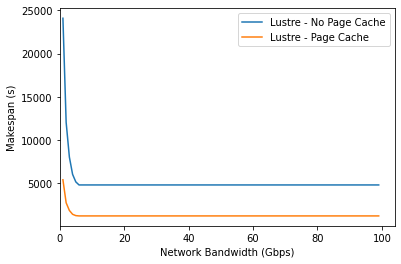

In [11]:
# bw = range(128, 100*128, 128)
# gbps = [b/128 for b in bw]

# n_cnodes = 5
# n_dnodes = 4
# mem_r = 6760*7
# mem_w = 2560*7
# lustre_disks = 11
# lustre_r = 50

# lustre_read = (lambda
#     num_read,
#     network_bw,
#     n_cnodes,
#     n_dnodes,
#     file_size,
#     n_threads: (num_read * file_size) / min ((network_bw * n_cnodes), (network_bw * n_dnodes),
#                                               lustre_r * min(lustre_disks * n_dnodes, n_cnodes * n_threads)))

# lpc_mksp = (lambda
#     n_files,
#     n_its,
#     network_bw,
#     n_cnodes,
#     n_dnodes,
#     file_size,
#     a_mem,
#     n_threads,
#     in_data,
#     b_mr,
#     dirty_ratio,
#     b_mw : (lustre_read(n_written(n_files, 1), network_bw, n_cnodes, n_dnodes, file_size, n_threads)
#                  + m_pread(n_nodes, n_its, a_mem, file_size, n_threads, in_data, b_mr)
#                  + (((in_data * (n_its - 1)) - cached_read(n_nodes, n_its, a_mem, file_size, n_threads, in_data))
#                     / min (network_bw * n_cnodes, network_bw * n_dnodes, (n_threads * n_cnodes) / n_dnodes))
#                  + m_pwrite(dirty_ratio, n_cnodes, n_its, a_mem, file_size, n_threads, in_data, b_mw)
#                  + (((n_its * in_data) - cached_write(dirty_ratio, n_nodes, n_its, a_mem, file_size, n_threads, in_data))
#                     / min (network_bw * n_cnodes, network_bw * n_dnodes, (n_threads * n_cnodes) / n_dnodes))))


# #lustre = [lpc_mksp(num_files, n_iterations, b, n_cnodes, n_dnodes, file_size, a_mem, n_threads, num_files*file_size, mem_r, dirty_ratio, mem_w) for b in bw]
# #sea = [spc_mksp(num_files, n_iterations, b, n_nodes, file_size, n_threads, n_disks, dirty_ratio, a_mem, num_files*file_size, mem_r, mem_w) for b in bw]

F = 617
n_f = 1000
D_in = F * n_f
N_c = 5
N_d = 4
I = 10
C = 0.40
A = 200 * 1024
n = 6
O = 44
B_n = 25 * 128
B_lr = 100 #200
B_lw = 75 #191
B_mr = 6760 * 7
B_mw = 2560 * 7

lustre_npc = [M_l(D_in, I, O, N_c, N_d, b, B_lr, B_lw) for b in bw]
lustre_pc = [M_lpc(D_in, N_c, N_d, I, C, A, F, n, O, b, B_lr, B_lw, B_mr, B_mw) for b in bw]

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=gbps, y=lustre_npc, label="Lustre - No Page Cache")
sns.lineplot(x=gbps, y=lustre_pc, label="Lustre - Page Cache")
#sns.lineplot(x=gbps, y=sea, label="Sea - Flush last")
plt.xlabel("Network Bandwidth (Gbps)")
plt.ylabel("Makespan (s)")
plt.xlim(0)

### Model evaluation - Number of nodes

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = range(1,9)
b = 50*128
num_files = 1000
n_iterations = 10
n_cnodes = 5
n_dnodes = 4
file_size = 617
a_mem = 200 * 1024
n_threads = 6
mem_r = 6760*7
mem_w = 2560*7
dirty_ratio = 0.4
network_bw = 60*128
lustre_r=1000
#lustre = [lpc_mksp(num_files, n_iterations, b, n, n_dnodes, file_size, a_mem, n_threads, num_files*file_size, mem_r, dirty_ratio, mem_w) for n in nodes]
lustre_npc = [M_l(D_in, I, O, nc, N_d, B_n, B_lr, B_lw) for nc in nodes]
lustre_pc = [M_lpc(D_in, nc, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for nc in nodes]
sea = [spc_mksp(num_files, n_iterations, b, n, file_size, n_threads, n_disks, dirty_ratio, a_mem, num_files*file_size, mem_r, mem_w) for n in nodes]

df = pd.read_csv("../results/exp_6t_5i_n35.out")
df["nodes"] = df["experiment"].apply(lambda row: int(row.split('n_')[0].split("_")[-1]))
df["experiment"] = df["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))

df_lustre=df[df["experiment"] == "lustre"]
df_last=df[df["experiment"] == "mem"]

#sns.lineplot(x=nodes, y=lustre_npc, label="Lustre - No Page Cache(model)")
sns.lineplot(x=nodes, y=lustre_pc, label="Lustre - Page Cache(model)")
sns.lineplot(x=nodes, y=sea, label="Sea - Flush last (model)")
sns.scatterplot(data=df_lustre, x="nodes", y="runtime", label="Lustre (real)")
#sns.scatterplot(data=df_last, x="nodes", y="runtime", label="Sea - Flush last (real)")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")

TypeError: <lambda>() missing 2 required positional arguments: 'file_size' and 'n_threads'

### Model evaluation - Number of disks

Text(0, 0.5, 'Makespan (s)')

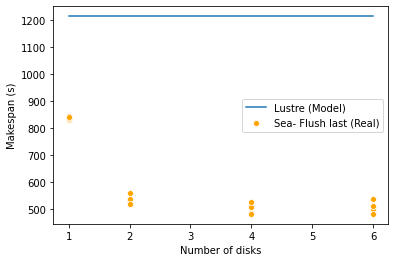

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
disks = range(1, 7)

#lustre = [lpc_mksp(num_files, n_iterations, b, nodes, file_size, a_mem, n_threads, num_files*file_size, mem_r, dirty_ratio, mem_w) for d in disks]
lustre = [M_lpc(D_in, N_c, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for d in disks]
#sea = [spc_mksp(num_files, n_iterations, b, nodes, file_size, n_threads, d, dirty_ratio, a_mem, num_files*file_size, mem_r, mem_w) for d in disks]

df = pd.read_csv("../results/experiment_disks.out")
df = df[(df["experiment"].str.contains("mem"))]
df["disks"] = df["experiment"].apply(lambda name: int(name.split("d_")[0].split("_")[-1]))
df = df.sort_values(by=['disks'])

sns.lineplot(x=disks, y=lustre, label="Lustre (Model)")
#sns.lineplot(x=disks, y=sea, label="Sea - Flush last (Model)")
sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="orange")
plt.xlabel("Number of disks")
plt.ylabel("Makespan (s)")

### Model evaluation - Number of iterations

(0.0, 20.0)

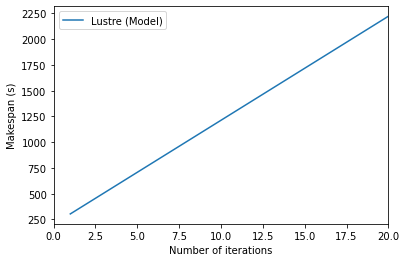

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
d = 6
n_iterations = range(1, 21)

#lustre = [lpc_mksp(num_files, i, b, nodes, file_size, a_mem, n_threads, num_files*file_size, mem_r, dirty_ratio, mem_w)  for i in n_iterations]
lustre = [M_lpc(D_in, N_c, i, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for i in n_iterations]
#sea = [spc_mksp(num_files, i, b, nodes, file_size, n_threads, d, dirty_ratio, a_mem, num_files*file_size, mem_r, mem_w) for i in n_iterations]


sns.lineplot(x=n_iterations, y=lustre, label="Lustre (Model)")
#sns.lineplot(x=n_iterations, y=sea, label="Sea - Flush last (Model)")
#sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="orange")
plt.xlabel("Number of iterations")
plt.ylabel("Makespan (s)")
plt.xlim(0, 20)

### Model evaluation - Number of files

(0.0, 76664.12517779216)

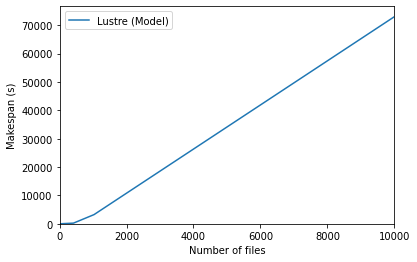

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
d = 6
i = 5
num_files = range(0, 10001)

lustre = [M_lpc(f*n_f, N_c, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for f in num_files]

#lustre = [lpc_mksp(f, i, b, nodes, file_size, a_mem, n_threads, f*file_size, mem_r, dirty_ratio, mem_w) for f in num_files]
#sea = [spc_mksp(f, i, b, nodes, file_size, n_threads, d, dirty_ratio, a_mem, f*file_size, mem_r, mem_w) for f in num_files]


sns.lineplot(x=num_files, y=lustre, label="Lustre (Model)")
#sns.lineplot(x=num_files, y=sea, label="Sea - Flush last (Model)")
#sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="orange")
plt.xlabel("Number of files")
plt.ylabel("Makespan (s)")
plt.xlim(0,10001)
plt.ylim(0)

### Model evaluation - Number of threads

(0.0, 7150.041990599944)

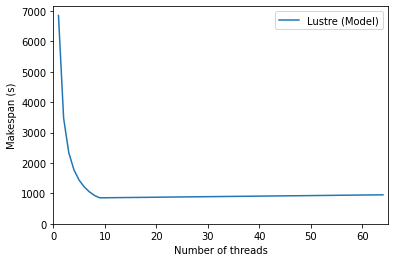

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
d = 6
i = 5
f = 1000
threads = range(1, 65)

#lustre = [lpc_mksp(f, i, b, nodes, file_size, a_mem, t, f*file_size, mem_r, dirty_ratio, mem_w) for t in threads]
#sea = [spc_mksp(f, i, b, nodes, file_size, t, d, dirty_ratio, a_mem, f*file_size, mem_r, mem_w) for t in threads]
lustre = [M_lpc(D_in, N_c, N_d, I, C, A, F, t, O, B_n, B_lr, B_lw, B_mr, B_mw) for t in threads]


sns.lineplot(x=threads, y=lustre, label="Lustre (Model)")
#sns.lineplot(x=threads, y=sea, label="Sea - Flush last (Model)")
#sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="orange")
plt.xlabel("Number of threads")
plt.ylabel("Makespan (s)")
plt.xlim(0,65)
plt.ylim(0)

In [ ]:
lustre_read = (lambda
    num_read,
    network_bw,
    n_cnodes,
    n_dnodes,
    file_size,
    n_threads: (num_read * file_size) / min ((network_bw * n_cnodes), (network_bw * n_dnodes),
                                              lustre_r * min(lustre_disks * lustre_nodes, n_cnodes * n_threads)))
lustre_r = 50
lustre_disks = 11
lustre_nodes = 4
network = 25*128
file_size = 617
n_threads = 6
#lustre_read(1000, 15*128, 3, 4, file_size)
print("network", network*3, network * lustre_nodes,lustre_r * min(lustre_disks * lustre_nodes, 3 * 6))
print("lustre", lustre_r * min(lustre_disks,1))
lustre_read(1000, network, 3, 4, 617,n_threads)



In [ ]:
lustre_read(1000, network, 5, 4, file_size, n_threads)

In [ ]:
lustre_read(1000, network, 8, 4, file_size, n_threads)

In [ ]:
n_its = 1
in_data = 617*1000
lustre_r = 50
mem_r = 6760*7
mem_w = 2560*7
lpc_mksp = (lambda
    n_files,
    n_its,
    network_bw,
    n_cnodes,
    n_dnodes,
    file_size,
    a_mem,
    n_threads,
    in_data,
    b_mr,
    dirty_ratio,
    b_mw : (lustre_read(n_written(n_files, 1), network_bw, n_cnodes, n_dnodes, file_size, n_threads)
                 + m_pread(n_nodes, n_its, a_mem, file_size, n_threads, in_data, b_mr)
                 + (((in_data * (n_its - 1)) - cached_read(n_nodes, n_its, a_mem, file_size, n_threads, in_data))
                    / min (network_bw * n_cnodes, network_bw * n_dnodes, (n_threads * n_cnodes) / n_dnodes))
                 + m_pwrite(dirty_ratio, n_cnodes, n_its, a_mem, file_size, n_threads, in_data, b_mw)
                 + (((n_its * in_data) - cached_write(dirty_ratio, n_nodes, n_its, a_mem, file_size, n_threads, in_data))
                    / min (network_bw * n_cnodes, network_bw * n_dnodes, (n_threads * n_cnodes) / n_dnodes))))


(((1 * 617*1000) - cached_write(0.4, 3, 1, 200*1024, 617, 1, 617*1000))
                    / min (25*128 *3, 25*128 *4, lustre_r * min(11 * 4, 3 * 1)))

(1 * 617*1000) #- 
cached_write(0.4, 3, 1, 400*1024, 617, 6, 617*1000)
lustre_read(n_written(1000, 1), network, 3, 4, 617, 6)

In [ ]:
lpc_mksp(1000, 1, 25*128, 3, 4, 617, 400*1024, 6, 1000*617, mem_r, 0.40, mem_w)

In [ ]:
lpc_mksp(1000, 1, 25*128, 5, 4, 617, 400*1024, 6, 1000*617, mem_r, 0.40, mem_w)

In [ ]:
lpc_mksp(1000, 1, 25*128, 8, 4, 617, 400*1024, 6, 1000*617, mem_r, 0.40, mem_w)

In [35]:
nbw = 25*128
M_lpc(D_in, 3, N_d, 1, C, A, F, n, O, nbw, 200, 200, B_mr, B_mw)

279.65822271825397

In [34]:
M_lpc(D_in, 5, N_d, 1, C, A, F, n, O, nbw, 200, 200, B_mr, B_mw)

142.54711160714285

In [33]:
M_lpc(D_in, 8, N_d, 1, C, A, F, n, O, nbw, 200, 200, B_mr, B_mw)

74.41748681006493

In [20]:
D_in / min(B_n * N_c, B_n * N_d, B_lr * O)

140.22727272727272

In [21]:
(617*1000)/(B_n * 3), (B_n * 3), B_n, 3

(64.27083333333333, 9600, 3200, 3)

In [22]:
(617*1000)/(B_n * N_d), (B_n * N_d), B_n, N_d

(48.203125, 12800, 3200, 4)